### Pangeo: Timeseries of Global Near Surface Temperature and Precipitation Anomalies from Multiple Models

In this example we search for datasets with both historical and ssp-data and calculate the mean value of these models.

**Packages:**

- matplotlib
- numpy
- pandas 
    - *tool for reading data*, *data analysis and manipulation*
- xarray 
    - *for handling of multidimensional arrays*
- intake 
    - *for finding, investigating and loading data*
- intake-esm 
    - *for connecting to database and loading data into xarray.Datasets, (built on top of pandas, xarray and intake)*

In [2]:
import xarray as xr 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#package for sharing and loading datasets
import intake

In [3]:
#url for connecting to Pangeo
url = 'https://storage.googleapis.com/cmip6/pangeo-cmip6.json'

#opening data catalog using intake_esm
dataframe = intake.open_esm_datastore(url)

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
#searching for models that have both historical and ssp119 datasets
query = dict(
    experiment_id=['historical', 'ssp119'],
    table_id='Amon',
    variable_id='tas',
    member_id = 'r1i1p1f1',
)

tas_models = dataframe.search(require_all_on=["source_id"], **query)
tas_models.df.groupby("source_id").nunique()

,activity_id,institution_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
source_id,,,,,,,,,,
CAMS-CSM1-0,2,1,2,1,1,1,1,2,0,1
CanESM5,2,1,2,1,1,1,1,2,0,1
EC-Earth3-Veg,2,1,2,1,1,1,1,2,0,2
EC-Earth3-Veg-LR,2,1,2,1,1,1,1,2,0,2
FGOALS-g3,2,1,2,1,1,1,1,2,0,2
GFDL-ESM4,2,1,2,1,1,1,1,2,0,2
IPSL-CM6A-LR,2,1,2,1,1,1,1,2,0,2
MIROC6,2,1,2,1,1,1,1,2,0,2
MRI-ESM2-0,2,1,2,1,1,1,1,2,0,1


In [6]:
#datasets into dictionary where they can be accessed
tas_datasets = tas_models.to_dataset_dict()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [7]:
#calculate global mean

def GlobalMean(data):
    #creating weights to weight data according to surface area
    weights = np.cos(np.deg2rad(data.lat))
    weights.name = "weights"
    #calculating weighted global means
    data_weighted = data.weighted(weights)
    weighted_mean = data_weighted.mean(("lon", "lat"))
    return weighted_mean

In [8]:
ds_tas = []

#calculating annual global means for each dataset
for key in tas_datasets.keys():
    ds_tas.append(GlobalMean(tas_datasets[key].tas.groupby('time.year').mean('time')))
    print(key)

CMIP.MIROC.MIROC6.historical.Amon.gn
CMIP.EC-Earth-Consortium.EC-Earth3-Veg-LR.historical.Amon.gr
CMIP.EC-Earth-Consortium.EC-Earth3-Veg.historical.Amon.gr
CMIP.NOAA-GFDL.GFDL-ESM4.historical.Amon.gr1
ScenarioMIP.MRI.MRI-ESM2-0.ssp119.Amon.gn
CMIP.CCCma.CanESM5.historical.Amon.gn
ScenarioMIP.EC-Earth-Consortium.EC-Earth3-Veg.ssp119.Amon.gr
ScenarioMIP.IPSL.IPSL-CM6A-LR.ssp119.Amon.gr
CMIP.MRI.MRI-ESM2-0.historical.Amon.gn
ScenarioMIP.NOAA-GFDL.GFDL-ESM4.ssp119.Amon.gr1
CMIP.CAS.FGOALS-g3.historical.Amon.gn
ScenarioMIP.CAS.FGOALS-g3.ssp119.Amon.gn
ScenarioMIP.CCCma.CanESM5.ssp119.Amon.gn
ScenarioMIP.CAMS.CAMS-CSM1-0.ssp119.Amon.gn
CMIP.IPSL.IPSL-CM6A-LR.historical.Amon.gr
CMIP.CAMS.CAMS-CSM1-0.historical.Amon.gn
ScenarioMIP.EC-Earth-Consortium.EC-Earth3-Veg-LR.ssp119.Amon.gr
ScenarioMIP.MIROC.MIROC6.ssp119.Amon.gn


In [9]:
#calculationg mean over different models
tas_mean = xr.concat(ds_tas, pd.Index(tas_datasets.keys(), name="source_id"), coords='minimal').mean('source_id')
tas_mean

<xarray.DataArray 'tas' (member_id: 1, year: 251)>
dask.array<mean_agg-aggregate, shape=(1, 251), dtype=float64, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
  * year       (year) int64 1850 1851 1852 1853 1854 ... 2097 2098 2099 2100
    height     float64 2.0
  * member_id  (member_id) <U8 'r1i1p1f1'

In [10]:
from dask.diagnostics import ProgressBar

#loading data into memory with progressbar
with ProgressBar():
    results = tas_mean.load()

[########################################] | 100% Completed |  5min 29.7s


In [11]:
#calculating mean value of reference period
tas_rel = results.sel(year = slice('1850','1900')).mean('year')
tas_rel

<xarray.DataArray 'tas' (member_id: 1)>
array([286.90166412])
Coordinates:
    height     float64 2.0
  * member_id  (member_id) <U8 'r1i1p1f1'

In [12]:
#surface temperature anomaly
data = results-tas_rel
data

<xarray.DataArray 'tas' (member_id: 1, year: 251)>
array([[-3.32783110e-02, -8.66944468e-02, -1.83879888e-02,
         1.28061791e-02, -3.03083659e-02,  2.10093569e-02,
         9.62401565e-03, -1.57431400e-02,  1.86068647e-03,
         4.77943538e-02, -1.83800057e-02, -7.61339111e-03,
        -7.47331508e-02, -4.89456169e-02, -7.90928163e-02,
        -4.93120547e-02,  2.37383007e-02,  1.68785794e-02,
        -1.39351887e-03, -3.10943090e-02, -1.45765866e-02,
         3.37274618e-02,  6.11784053e-02,  2.80713479e-02,
        -3.10433450e-02, -1.26823638e-02,  7.93442143e-03,
         4.62882708e-02,  6.83164059e-02,  9.58302538e-03,
         5.07840430e-02,  3.70215101e-02,  8.75997622e-03,
         3.94597982e-02, -2.94366807e-01, -2.55618506e-01,
        -1.34435512e-01, -9.44101223e-02, -5.68348199e-02,
        -5.57727802e-02, -3.01988281e-02, -2.49514067e-02,
         5.74221267e-02,  4.27033575e-02,  1.03231774e-01,
         1.33484716e-01,  1.19224741e-01,  9.89505232e-02,
         1.14938468e-01,  1.42406496e-01,  1.62669854e-01,
         1.19521952e-01,  1.14379162e-01, -1.05075335e-01,
        -5.52802528e-02, -1.12963959e-02, -1.47241440e-02,
         3.76439330e-02,  1.20185172e-01,  1.28690844e-01,
...
         1.64582634e+00,  1.59874256e+00,  1.63096973e+00,
         1.72771037e+00,  1.69942697e+00,  1.67082102e+00,
         1.72008511e+00,  1.62347259e+00,  1.58729258e+00,
         1.66171903e+00,  1.66612791e+00,  1.65501662e+00,
         1.62017430e+00,  1.56802006e+00,  1.58665035e+00,
         1.61681715e+00,  1.60764878e+00,  1.59147169e+00,
         1.56954116e+00,  1.59802177e+00,  1.59612268e+00,
         1.60482045e+00,  1.57610196e+00,  1.58010989e+00,
         1.57085069e+00,  1.58510805e+00,  1.57462131e+00,
         1.57513776e+00,  1.51306512e+00,  1.57049147e+00,
         1.50317017e+00,  1.47755402e+00,  1.50659857e+00,
         1.48235714e+00,  1.49938154e+00,  1.51544566e+00,
         1.49433373e+00,  1.51083187e+00,  1.56542644e+00,
         1.53897165e+00,  1.54942747e+00,  1.57849787e+00,
         1.55868161e+00,  1.49944994e+00,  1.45237412e+00,
         1.46069616e+00,  1.45299396e+00,  1.42411050e+00,
         1.47505339e+00,  1.47335442e+00,  1.45188347e+00,
         1.43061252e+00,  1.41324595e+00,  1.40037683e+00,
         1.37005243e+00,  1.38959712e+00,  1.34751670e+00,
         1.36766340e+00,  1.50704605e+00]])
Coordinates:
  * year       (year) int64 1850 1851 1852 1853 1854 ... 2097 2098 2099 2100
    height     float64 2.0
  * member_id  (member_id) <U8 'r1i1p1f1'

In [13]:
#searching for models that have both historical and ssp119 datasets
query = dict(
    experiment_id=['historical', 'ssp119'],
    table_id='Amon',
    variable_id=['pr'],
    member_id = 'r1i1p1f1',
)

pr_models = dataframe.search(require_all_on=["source_id"], **query)
pr_models.df.groupby("source_id").nunique()

,activity_id,institution_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
source_id,,,,,,,,,,
CAMS-CSM1-0,2,1,2,1,1,1,1,2,0,1
CanESM5,2,1,2,1,1,1,1,2,0,1
EC-Earth3-Veg,2,1,2,1,1,1,1,2,0,2
EC-Earth3-Veg-LR,2,1,2,1,1,1,1,2,0,2
FGOALS-g3,2,1,2,1,1,1,1,2,0,2
GFDL-ESM4,2,1,2,1,1,1,1,2,0,2
IPSL-CM6A-LR,2,1,2,1,1,1,1,2,0,2
MIROC6,2,1,2,1,1,1,1,2,0,2
MRI-ESM2-0,2,1,2,1,1,1,1,2,0,1


In [14]:
#loading datasets into dictionary where they can be easily accessed
pr_datasets = pr_models.to_dataset_dict()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [15]:
ds_pr = []

#annual global means of each dataset
for key in pr_datasets.keys():
    ds_pr.append(GlobalMean(pr_datasets[key].pr.groupby('time.year').mean('time')))
    print(key)

CMIP.MIROC.MIROC6.historical.Amon.gn
CMIP.EC-Earth-Consortium.EC-Earth3-Veg.historical.Amon.gr
CMIP.EC-Earth-Consortium.EC-Earth3-Veg-LR.historical.Amon.gr
CMIP.NOAA-GFDL.GFDL-ESM4.historical.Amon.gr1
CMIP.CCCma.CanESM5.historical.Amon.gn
ScenarioMIP.IPSL.IPSL-CM6A-LR.ssp119.Amon.gr
ScenarioMIP.MRI.MRI-ESM2-0.ssp119.Amon.gn
ScenarioMIP.EC-Earth-Consortium.EC-Earth3-Veg.ssp119.Amon.gr
CMIP.CAS.FGOALS-g3.historical.Amon.gn
CMIP.MRI.MRI-ESM2-0.historical.Amon.gn
ScenarioMIP.NOAA-GFDL.GFDL-ESM4.ssp119.Amon.gr1
ScenarioMIP.CAS.FGOALS-g3.ssp119.Amon.gn
ScenarioMIP.CAMS.CAMS-CSM1-0.ssp119.Amon.gn
ScenarioMIP.CCCma.CanESM5.ssp119.Amon.gn
CMIP.IPSL.IPSL-CM6A-LR.historical.Amon.gr
CMIP.CAMS.CAMS-CSM1-0.historical.Amon.gn
ScenarioMIP.MIROC.MIROC6.ssp119.Amon.gn
ScenarioMIP.EC-Earth-Consortium.EC-Earth3-Veg-LR.ssp119.Amon.gr


In [16]:
#calculationg mean over different models
pr_mean = xr.concat(ds_pr, pd.Index(pr_datasets.keys(), name="source_id"), coords='minimal').mean('source_id')
pr_mean

<xarray.DataArray 'pr' (member_id: 1, year: 251)>
dask.array<mean_agg-aggregate, shape=(1, 251), dtype=float64, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
  * year       (year) int64 1850 1851 1852 1853 1854 ... 2097 2098 2099 2100
  * member_id  (member_id) <U8 'r1i1p1f1'

In [17]:
#loading data into memory
with ProgressBar():
    results2 = pr_mean.load()

[########################################] | 100% Completed |  7min 46.8s


In [18]:
#mean precipitation of reference period
pr_rel = results2.sel(year = slice('1850','1900')).mean('year')
pr_rel

<xarray.DataArray 'pr' (member_id: 1)>
array([3.36953524e-05])
Coordinates:
  * member_id  (member_id) <U8 'r1i1p1f1'

In [19]:
#precipitation anomaly
data2 = results2-pr_rel
data2

<xarray.DataArray 'pr' (member_id: 1, year: 251)>
array([[ 3.41883726e-08, -3.86968196e-08,  3.56548664e-08,
         4.76651830e-08,  5.90051650e-09,  8.83034076e-08,
         5.84298847e-08, -2.79094618e-08,  2.33053414e-08,
         1.76405041e-08, -8.70255713e-09,  2.53985677e-08,
        -8.19681199e-08, -1.85933969e-08, -5.17236182e-08,
        -2.71932168e-08, -1.89339575e-08, -3.17681348e-08,
         9.48478260e-08,  4.74157112e-08, -2.80320656e-08,
         8.21815059e-09,  6.96496448e-08,  8.80500516e-08,
         1.66195438e-08,  2.65236592e-08, -8.16081557e-09,
         3.87245367e-08,  7.19616003e-08,  5.58256046e-08,
         3.00871715e-08,  4.00918480e-08,  2.12063623e-08,
        -3.14993311e-08, -2.74968784e-07, -2.82857086e-07,
        -1.17020857e-07, -1.11286000e-07, -6.54117751e-08,
        -5.91300029e-08, -2.03584883e-08, -2.41980843e-09,
         3.18433825e-09, -7.52780227e-09,  7.13676884e-09,
         8.67270770e-08,  6.83091864e-08,  3.56981660e-08,
         2.72939787e-08,  9.50323663e-08,  4.50718624e-08,
         1.48662965e-08,  1.14980844e-07, -2.75041721e-08,
        -7.02715947e-08, -7.75824041e-08, -9.78612630e-08,
        -9.57848645e-08,  3.21492319e-08,  7.02003253e-08,
...
         8.17497174e-07,  8.38101136e-07,  7.99470793e-07,
         8.75259084e-07,  9.00827807e-07,  8.40678525e-07,
         9.75013637e-07,  9.16051870e-07,  7.55978367e-07,
         8.59746845e-07,  8.91168544e-07,  9.40299406e-07,
         9.58821281e-07,  7.57358683e-07,  8.35951623e-07,
         9.08039360e-07,  8.98382382e-07,  9.23842515e-07,
         7.93592616e-07,  8.83168690e-07,  8.98884980e-07,
         8.55913411e-07,  8.31926172e-07,  8.42330917e-07,
         8.56402925e-07,  8.66344607e-07,  9.26110226e-07,
         9.74786435e-07,  7.55557496e-07,  8.86712992e-07,
         8.16946509e-07,  8.01381896e-07,  9.44790867e-07,
         8.15534718e-07,  8.17522657e-07,  8.18395167e-07,
         7.91717606e-07,  8.59639637e-07,  8.51929618e-07,
         7.81019767e-07,  8.77004764e-07,  8.75566039e-07,
         8.56687119e-07,  8.41407822e-07,  7.71216883e-07,
         8.64733366e-07,  8.78314525e-07,  7.88280364e-07,
         8.37132223e-07,  8.26597854e-07,  8.02454912e-07,
         8.23087900e-07,  8.64105401e-07,  7.78764134e-07,
         7.62701582e-07,  8.28296633e-07,  8.00819259e-07,
         8.26717543e-07,  1.11294475e-06]])
Coordinates:
  * year       (year) int64 1850 1851 1852 1853 1854 ... 2097 2098 2099 2100
  * member_id  (member_id) <U8 'r1i1p1f1'

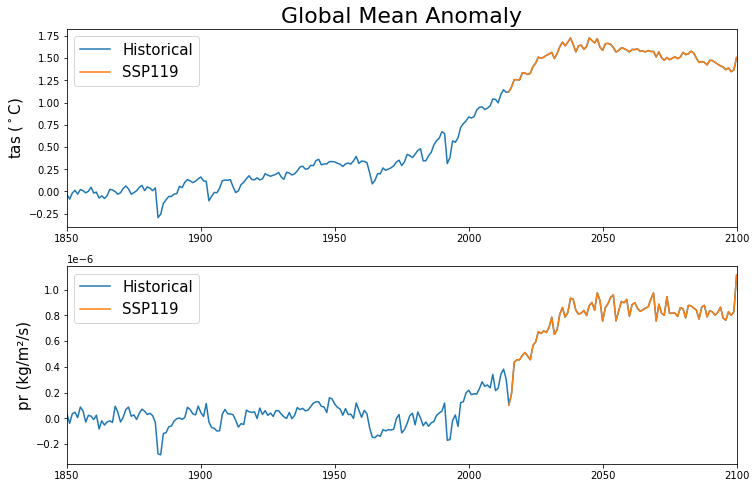

In [20]:
#creating a figure with two subplots
fig,[ax1,ax2] = plt.subplots(2, figsize=(12,8))

#Plot 1
ax1.plot(data.year, data.squeeze(), label='Historical')
ax1.plot(data.year.sel(year=slice(2015,2100)), data.squeeze().sel(year=slice(2015,2100)), label='SSP119')
ax1.set_ylabel('tas ($ ^\circ $C)', size=15)
ax1.set_title('Global Mean Anomaly', size=22)
ax1.set_xlim(1850,2100)
ax1.legend(fontsize=15)

#Plot 2
ax2.plot(data2.year, data2.squeeze(), label='Historical')
ax2.plot(data2.year.sel(year=slice(2015,2100)), data2.squeeze().sel(year=slice(2015,2100)), label='SSP119')
ax2.set_ylabel('pr (kg/m²/s)', size=15)
ax2.set_xlim(1850,2100)
ax2.legend(fontsize=15)
plt.show()